<a href="https://colab.research.google.com/github/aubricot/CV_for_flower_CT/blob/main/Cacao_Whole_Flower_Seg_unetr_inspect_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using MONAI Label for shape prediction of flowers from micro-CT images
---   
*Last Updated 31 Mar 2023*  
-Runs in Python 3 with Monai 1.5-   
This notebook inspects results of a trained UNETR Computer Vision Model ([Hatamizadeh et al. 2021](https://arxiv.org/abs/2103.10504)) using the [MONAI Label](https://github.com/aubricot/computer_vision_with_eol_images/tree/master/classification_for_image_tagging) framework. Datasets of micro-CT images and segementations (both as nifti files, .nii.gz) are run through the trained model (inference) and results are inspected and saved as image and segmentation files.

 U-Nets are a type of Convolutional Neural Network (CNN) shaped like a "U" with pairings of encoders (contracting path) and decoders (expanding path) who have gained popularity in recent years as a tool for segmentation of 3D image datasets ([Tomar 2021](https://medium.com/analytics-vidhya/what-is-unet-157314c87634&ved=2ahUKEwjeiK-myoyMAxX-QzABHb85DmQQFnoECBEQAQ&usg=AOvVaw1V_3fmv2Fckxy0QTuwS6LM)). UNETR has a similar network design/shape for the encoder and decoder as a U-Net, but UNET TRansformers (UNETR), uses a transformer as the encoder.

_References_

* [Hatamizadeh et al. 2021](https://arxiv.org/abs/2103.10504)   
* [Tomar 2021](https://medium.com/analytics-vidhya/what-is-unet-157314c87634&ved=2ahUKEwjeiK-myoyMAxX-QzABHb85DmQQFnoECBEQAQ&usg=AOvVaw1V_3fmv2Fckxy0QTuwS6LM)

_License_   
This notebook is licensed under an [MIT license](https://github.com/aubricot/CV_for_flower_CT/blob/master/LICENSE). Portions are modified from the MONAI Label [3D Multi-organ Segmentation with UNETR (BTCV Challenge)](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb) following licensing terms under Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0).

The section "Make sure runtime is set to GPU and High RAM" was modified from 3D Multi-organ Segmentation with UNETR (BTCV Challenge) to better suit our needs. All other portions of the notebook are our own.

## Installs & Imports
---

In [ ]:
#@title Make sure runtime is set to GPU and High RAM
# Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Mar 31 01:55:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
#@title Check how many workers are suggested for your system
# TO DO: Adjust num_workers throughout code to speed or slow performance based on available (cloud) hardware
import os

cpu_count = os.cpu_count()
if cpu_count is not None:
    max_num_worker_suggest = cpu_count

print("Suggested max number of workers is: ", max_num_worker_suggest)

Suggested max number of workers is:  12


In [ ]:
#@title Choose where to save results

# Use dropdown menu on right
save = "in my Google Drive" #@param ["in my Google Drive", "in Colab runtime (files deleted after each session)"]

# Mount google drive to export image tagging file(s)
if 'Google Drive' in save:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# Type in the path to your project wd in form field on right
wd = "/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data" # @param ["/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data","/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/demo_data/Abdomen/Abdomen/RawData/data"] {"allow-input":true}
print("Working with data from: \n")
%cd $wd

Mounted at /content/drive
Working with data from: 

/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data


In [ ]:
#@title Installs
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install nbconvert
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.5 MB/s eta 0:00:00


In [ ]:
#@title Imports
import os
import shutil
import tempfile
import glob
import math
import time

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.utils import first
from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureType,
    EnsureTyped,
    FgBgToIndicesd,
    Invertd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandSpatialCropd,
    Resized,
    SaveImaged,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNETR, unet
from torch.optim import Adam, SGD
from monai.optimizers import Novograd
from monai.apps import download_and_extract
from monai.data import NibabelReader

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    ThreadDataLoader,
    Dataset,
    set_track_meta,
)

# Facilitate debugging by making GPU tell more useful information
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

# Check that cuda is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available and being used.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU instead.")

print_config()

CUDA is available and being used.
MONAI version: 1.5.dev2513
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ef083a32ccc13ee3937a4bd8acc12b9cdc174e18
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.50.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, pleas

In [ ]:
#@title Set up data directory
os.environ['MONAI_DATA_DIRECTORY'] = wd
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = directory
print(f"root dir is: {root_dir}")

out_dir = wd + '/' + "results/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

print(f"out dir is: {out_dir}")

root dir is: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data
out dir is: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/


In [ ]:
#@title Set model parameters

# Use cuda GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# How many epochs to train for and how often to evaluate model performance
max_iterations = 2000 #@param
eval_num = 20 #@param

# Parameters
out_channels = 1 #@param
img_size = 96 #@param
feature_size = 32 # @param ["16","32","48","64","70","96"] {"type":"raw"}
hidden_size = 768 #@param
mlp_dim = 3072 #@param
num_heads = 12 #@param
norm_name = "instance" # @param ["instance","batch"]
res_block = True # @param {"type":"boolean"}
conv_block = True # @param {"type":"boolean"}
dropout_rate = 0.0 #@param
pos_embed = "perceptron" # @param ["conv","perceptron"]

# Define the model
model = UNETR(
    in_channels=1,
    out_channels=out_channels,
    img_size=(img_size, img_size, img_size),
    feature_size=feature_size,
    hidden_size=hidden_size,
    mlp_dim=mlp_dim,
    num_heads=num_heads,
    norm_name=norm_name,
    conv_block=conv_block,
    res_block=res_block,
    dropout_rate=dropout_rate,
    proj_type=pos_embed,
).to(device)

# Get model architecture info for pubs, etc
#print(len(model))
#print(model)

# Define the loss function
if out_channels > 1:
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
else:
    loss_function = DiceCELoss(include_background=False, sigmoid=True)

# Algorithmically optimize GPU training and speed things up, could be variable for val images since size varies
torch.backends.cudnn.benchmark = True #@param

# Set optimizer parameters
optimizer = "AdamW" # @param ["AdamW","Novograd"] {"allow-input":true}
lr = 0.8e-6 # @param ["1.5e-3","1e-3"] {"type":"raw","allow-input":true}
weight_decay = 2e-3 # @param ["1e-2","0","1e-3","1e-4","1e-1"] {"type":"raw","allow-input":true}
amsgrad = False # @param {"type":"boolean"}

# Set optimizer
if "Adam" in optimizer:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)
else:
    optimizer = Novograd(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)

## Visualize model layers for figure

In [ ]:
!pip install torchview
from torchview import draw_graph

graph = draw_graph(model, input_size=(1,1,96,96,96), expand_nested=True, save_graph=True, filename="unet_architecture")

In [ ]:
print(model)

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (to_q): Identity()
          (t

## Inspect Results

In [ ]:
#@title Dataset Transforms

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = False # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "132" # @param ["138","02","03"] {"allow-input":true}

# Define 3d predicted labels (nifti) dir
predict_labs_dir = os.path.join(out_dir, "predicted_labels_3d/")
predict_labs_dir = predict_labs_dir + TRAIN_SESS_NUM + '/'
if not os.path.exists(predict_labs_dir):
    os.makedirs(predict_labs_dir)

# Validation transforms
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear", "nearest"),),
        ScaleIntensityRangePercentilesd(
                keys="image",
                lower=10, upper=90, b_min=0, b_max=200,
                clip=False,
                relative=False,),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

## For original, masked validation images

In [ ]:
#@title Read validation images into runtime
data_root = os.path.join(root_dir, "input")

# Get image and label filepaths
val_images = sorted(glob.glob(os.path.join(data_root, "val/images", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(data_root, "val/labels", "*.nii.gz")))
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]
num_val = len(val_files)
print("Validation images loaded from {} \n Validation labels loaded from {}".format(val_images, val_labels))

# Transform datasets and read into cache for training
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=num_val, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

print("\n\nSample Validation image shape after transform: {}, label shape: {}".format(first(val_loader)['image'].shape, first(val_loader)['label'].shape))

Validation images loaded from ['/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/val/images/thecac_fbg_cg_220622_05_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/val/images/thecac_fbg_rph_220622_07_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/val/images/thecac_fbg_rph_220622_15_masked.nii.gz'] 
 Validation labels loaded from ['/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/val/labels/thecac_fbg_cg_220622_05_seg_reg.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/val/labels/thecac_fbg_rph_220622_07_seg_reg.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/val/labels/thecac_fbg_rph_220622_15_seg_reg.nii.gz']


Loading dataset:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/transforms/intensity/array.py:1000: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
Loading dataset: 100%|██████████| 3/3 [00:34<00:00, 11.51s/it]




Sample Validation image shape after transform: torch.Size([1, 1, 173, 232, 285]), label shape: torch.Size([1, 1, 173, 232, 285])


Inspecting results for: thecac_fbg_rph_220622_15_masked.nii.gz at slice number: 167
torch.Size([1, 1, 223, 242, 268])
torch.Size([1, 1, 223, 242, 268])
torch.Size([1, 1, 223, 242, 268])
Prediction images saved to:  /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/prediction_images/132/thecac_fbg_rph_220622_15_masked.nii.gz_slice_167.png


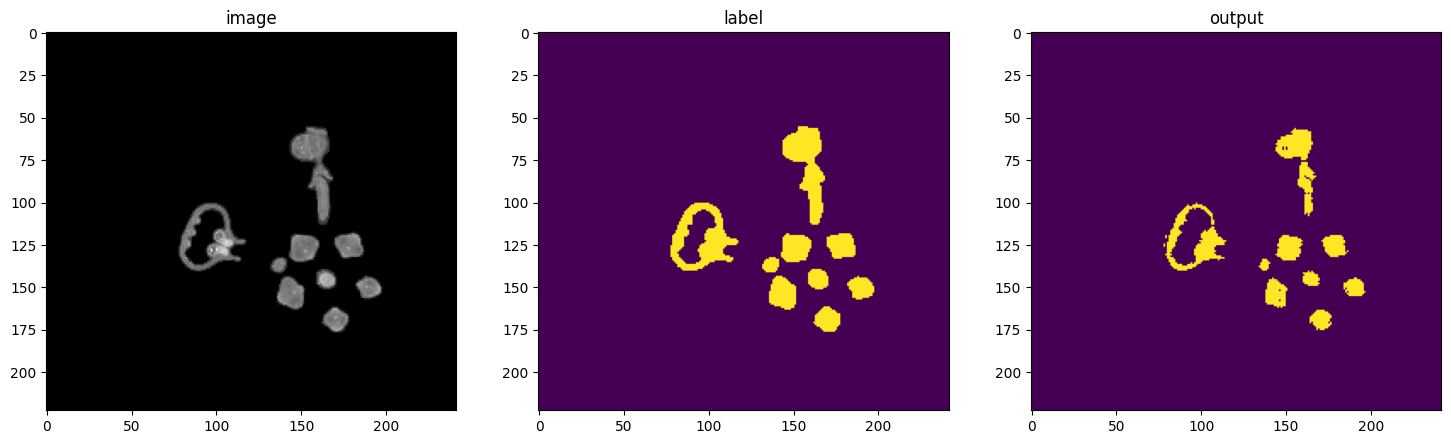

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 2 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 167 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Define prediction images dir
predict_imgs_dir = os.path.join(out_dir, "prediction_images/")
predict_imgs_dir = predict_imgs_dir + TRAIN_SESS_NUM + '/'
if not os.path.exists(predict_imgs_dir):
    os.makedirs(predict_imgs_dir)

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    print("Inspecting results for: {} at slice number: {}".format(img_name, slice_num))
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])

    # Save prediction images to file
    predict_img_fpath = predict_imgs_dir + str(img_name) + '_slice_' + str(slice_num) + '.png'
    plt.savefig(predict_img_fpath)
    print("Prediction images saved to: ", predict_img_fpath)

    plt.show()

## For original validation images, unmasked

In [ ]:
#@title Read validation images into runtime
data_root = os.path.join(root_dir, "input3")

# Get image and label filepaths
val_images = sorted(glob.glob(os.path.join(data_root, "val/images", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(data_root, "val/labels", "*.nii.gz")))
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]
print("Validation images loaded from {} \n Validation labels loaded from {}".format(val_images, val_labels))

# Transform datasets and read into cache for training
val_ds1 = CacheDataset(data=val_files, transform=val_transforms, cache_num=num_val, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds1, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

print("\n\nSample Validation image shape after transform: {}, label shape: {}".format(first(val_loader)['image'].shape, first(val_loader)['label'].shape))

Validation images loaded from ['/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input3/val/images/THE_USDA_MAR_(10)UM_HR_SS_PTA(14d)_.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input3/val/images/Thecac_fbg_RPH_220123_07_crop.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input3/val/images/thecac_fbg_cg_220622_05_crop.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input3/val/images/thecac_fbg_cg_220622_06_cropped.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input3/val/images/thecac_fbg_rph_220622_09_crop_mask.nii.gz'] 
 Validation labels loaded from ['/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input3/val/labels/THE_USDA_MAR_(10)UM_HR_SS_PTA(14d)__seg.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_C

Loading dataset: 100%|██████████| 3/3 [00:48<00:00, 16.25s/it]




Sample Validation image shape after transform: torch.Size([1, 1, 290, 303, 386]), label shape: torch.Size([1, 1, 290, 303, 386])


Inspecting results for: thecac_fbg_cg_220622_06_cropped.nii.gz at slice number: 302
torch.Size([1, 1, 255, 260, 352])
torch.Size([1, 1, 255, 260, 352])
torch.Size([1, 1, 255, 260, 352])
Prediction images saved to:  /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/prediction_images/132/thecac_fbg_cg_220622_06_cropped.nii.gz_masked_novel-test_slice_302.png


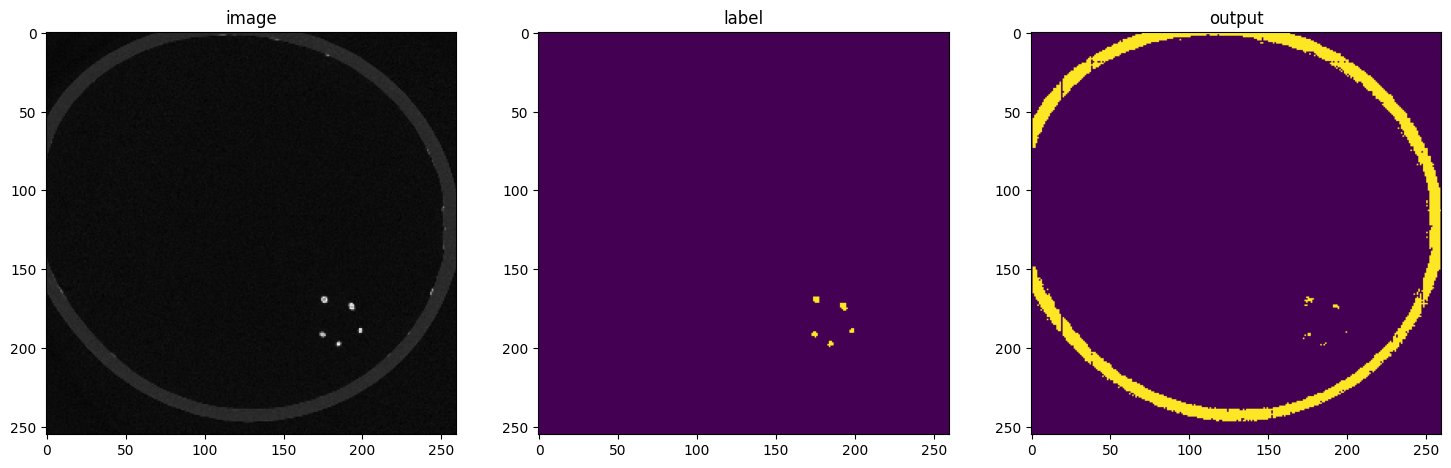

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 3 # @param {"type":"slider","min":0,"max":5,"step":1}
slice_num = 302 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Define prediction images dir
predict_imgs_dir = os.path.join(out_dir, "prediction_images/")
predict_imgs_dir = predict_imgs_dir + TRAIN_SESS_NUM + '/'
if not os.path.exists(predict_imgs_dir):
    os.makedirs(predict_imgs_dir)

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds1[val_img_idx]['image'].meta["filename_or_obj"])[1]
    print("Inspecting results for: {} at slice number: {}".format(img_name, slice_num))
    img = val_ds1[val_img_idx]["image"]
    label = val_ds1[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])

    # Save prediction images to file
    predict_img_fpath = predict_imgs_dir + str(img_name) + '_masked_novel-test' + '_slice_' + str(slice_num) + '.png'
    plt.savefig(predict_img_fpath)
    print("Prediction images saved to: ", predict_img_fpath)

    plt.show()

In [ ]:
#@title get DICE scores for novel images
import nibabel as nib
from monai.handlers.utils import from_engine
import numpy as np
import scipy.ndimage as ndimage


# Resample 3d label prediction to image shape
def resample_3d(image, image_shape, target_shape, mode="nearest"):
    zoom_factors = [t / s for t, s in zip(target_shape, image_shape)]
    print("Zoom factors for resample_3d: ", zoom_factors)
    return ndimage.zoom(image.cpu().numpy()[0,0,:,:,:], zoom_factors, order=0 if mode == "nearest" else 1)

# Load in saved model
saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Define DICE metric to use
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Define 3d predicted labels (nifti) dir
predict_labs_dir = os.path.join(out_dir, "predicted_labels_3d/")
predict_labs_dir = predict_labs_dir + TRAIN_SESS_NUM + '/'
if not os.path.exists(predict_labs_dir):
    os.makedirs(predict_labs_dir)

# Evaluate model performance
model.eval()
with torch.no_grad():
    dice_list = []

    # Check an image from the val dataset
    for val_img_idx in range(len(val_ds)):
        img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
        print("\nInspecting results for: {}\n".format(img_name))
        img = val_ds[val_img_idx]["image"]
        label = val_ds[val_img_idx]["label"]
        original_affine = val_ds[val_img_idx]['image'].meta["affine"].numpy()
        val_inputs = torch.unsqueeze(img, 1).cuda()
        print("Input image shape: ", val_inputs.shape)
        val_labels = torch.unsqueeze(label, 1).cuda()
        _, _, h, w, d = val_labels.shape
        target_shape = (h, w, d)
        print("Input label shape: ", val_labels.shape)
        # Run inference
        val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
        print("Output label shape: ", val_outputs.shape)
        _, _, h, w, d = val_outputs.shape
        val_outputs_shape = (h, w, d)

        # Calc DICE score
        post_label = Compose([AsDiscrete(n_classes=1)])
        post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
        val_outputs = post_pred(val_outputs)
        val_labels = post_label(val_labels)
        print("val_outputs shape: ", val_outputs.shape)
        print("val_labels shape: ", val_labels.shape)

        dice_metric = DiceMetric(include_background=False)
        dice = dice_metric(y_pred=val_outputs, y=val_labels).item()
        dice_list.append(dice)
        dice_metric.reset()
        print("\nDICE score for image {}: {}".format(img_name, dice))

        # Save predicted label images to nifti file for import into 3D slicer
        predict_lab_fpath = predict_labs_dir + str(img_name).replace(".nii.gz", "") + '_prediction' + '.nii.gz'
        print("\nPrediction labels saved to: ", predict_lab_fpath)
        val_outputs = resample_3d(val_outputs, val_outputs_shape, target_shape, mode="nearest")
        print("Validation outputs shape after resampling: ", val_outputs.shape)
        nib.save(nib.Nifti1Image(val_outputs.astype(np.uint8), original_affine), predict_lab_fpath)

        print("Overall Mean Dice: {}".format(np.mean(dice_list)))


Inspecting results for: thecac_fbg_cg_220622_05_masked.nii.gz

Input image shape:  torch.Size([1, 1, 173, 232, 285])
Input label shape:  torch.Size([1, 1, 173, 232, 285])
Output label shape:  torch.Size([1, 1, 173, 232, 285])
val_outputs shape:  torch.Size([1, 1, 173, 232, 285])
val_labels shape:  torch.Size([1, 1, 173, 232, 285])

DICE score for image thecac_fbg_cg_220622_05_masked.nii.gz: 0.0

Prediction labels saved to:  /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/predicted_labels_3d/132/thecac_fbg_cg_220622_05_masked_prediction.nii.gz
Zoom factors for resample_3d:  [1.0, 1.0, 1.0]
Validation outputs shape after resampling:  (173, 232, 285)
Overall Mean Dice: 0.0

Inspecting results for: thecac_fbg_rph_220622_07_masked.nii.gz

Input image shape:  torch.Size([1, 1, 218, 202, 276])
Input label shape:  torch.Size([1, 1, 218, 202, 276])
Output label shape:  torch.Size([1, 1, 218, 202, 276])
val_outputs shape:  torch.Size([1, 1, 218, 202, 2

torch.Size([1, 1, 173, 232, 285])
torch.Size([1, 1, 173, 232, 285])
torch.Size([1, 1, 173, 232, 285])


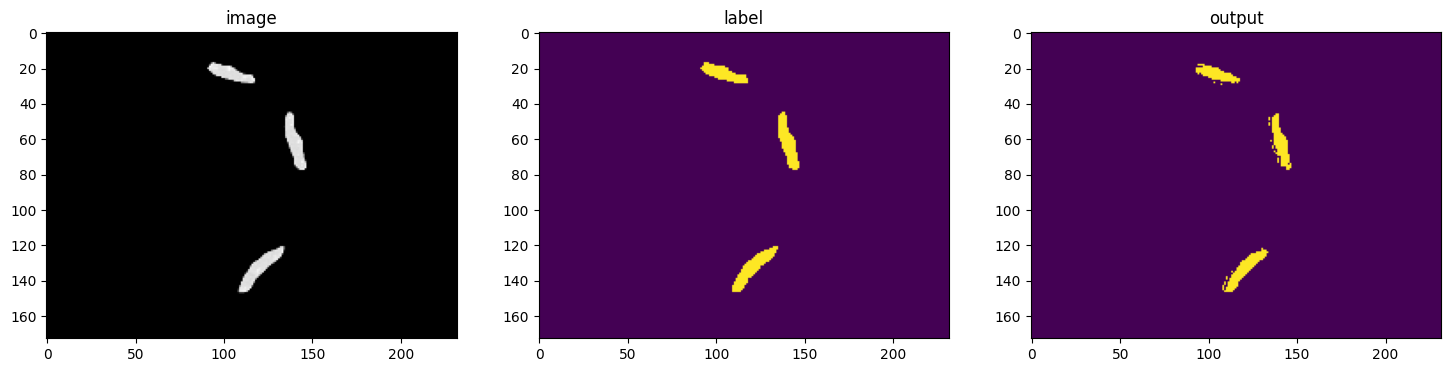

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 0 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 83 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()

torch.Size([1, 1, 173, 232, 285])
torch.Size([1, 1, 173, 232, 285])
torch.Size([1, 1, 173, 232, 285])


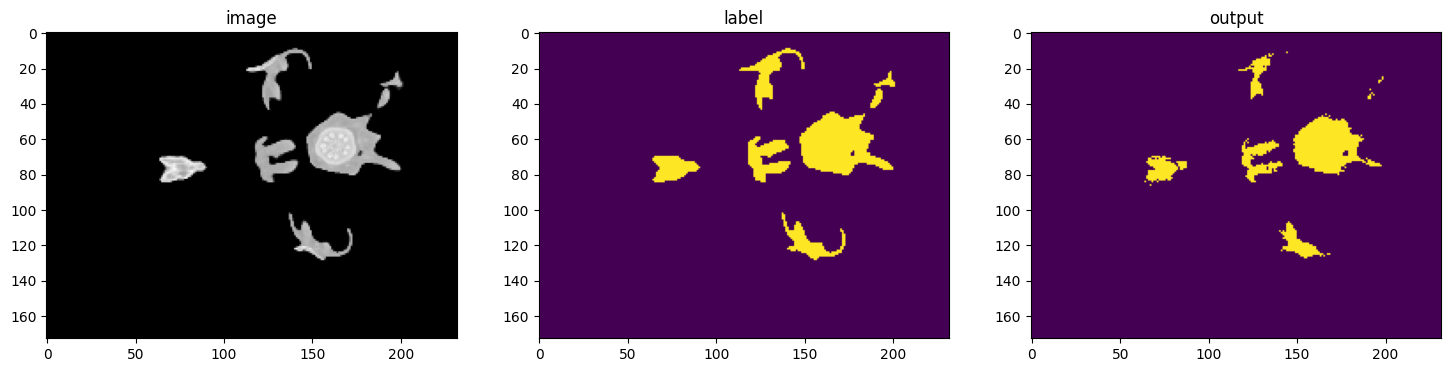

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 0 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 184 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()

torch.Size([1, 1, 218, 202, 276])
torch.Size([1, 1, 218, 202, 276])
torch.Size([1, 1, 218, 202, 276])


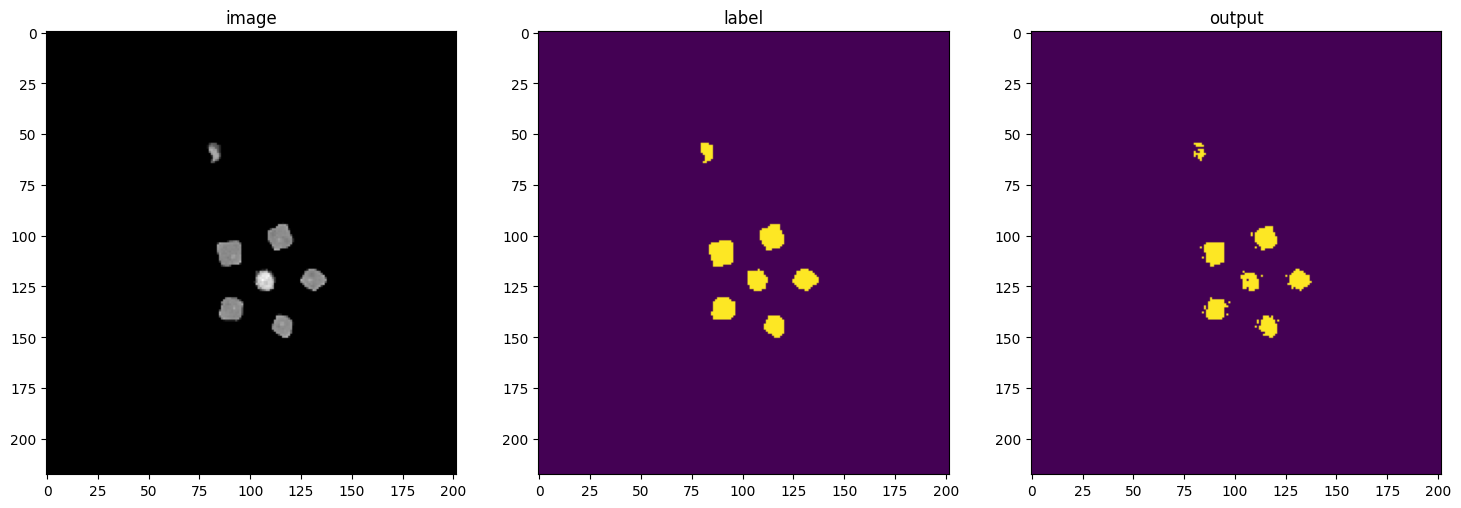

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 1 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 184 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()

torch.Size([1, 1, 218, 202, 276])
torch.Size([1, 1, 218, 202, 276])
torch.Size([1, 1, 218, 202, 276])


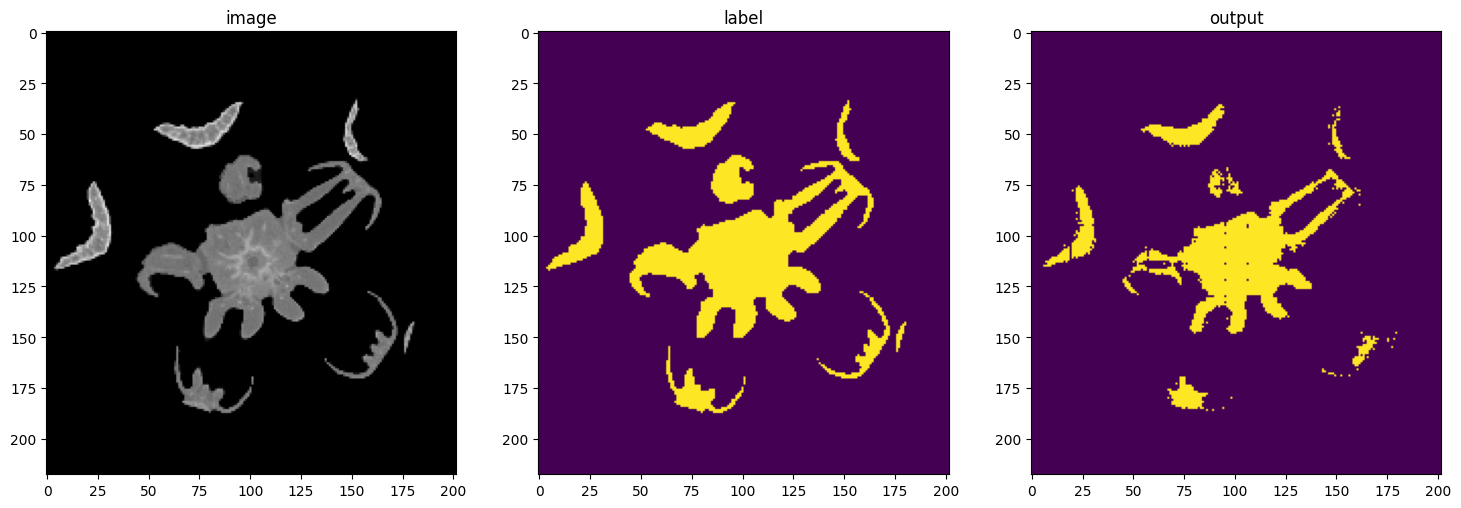

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 1 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 129 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()

torch.Size([1, 1, 218, 202, 276])
torch.Size([1, 1, 218, 202, 276])
torch.Size([1, 1, 218, 202, 276])


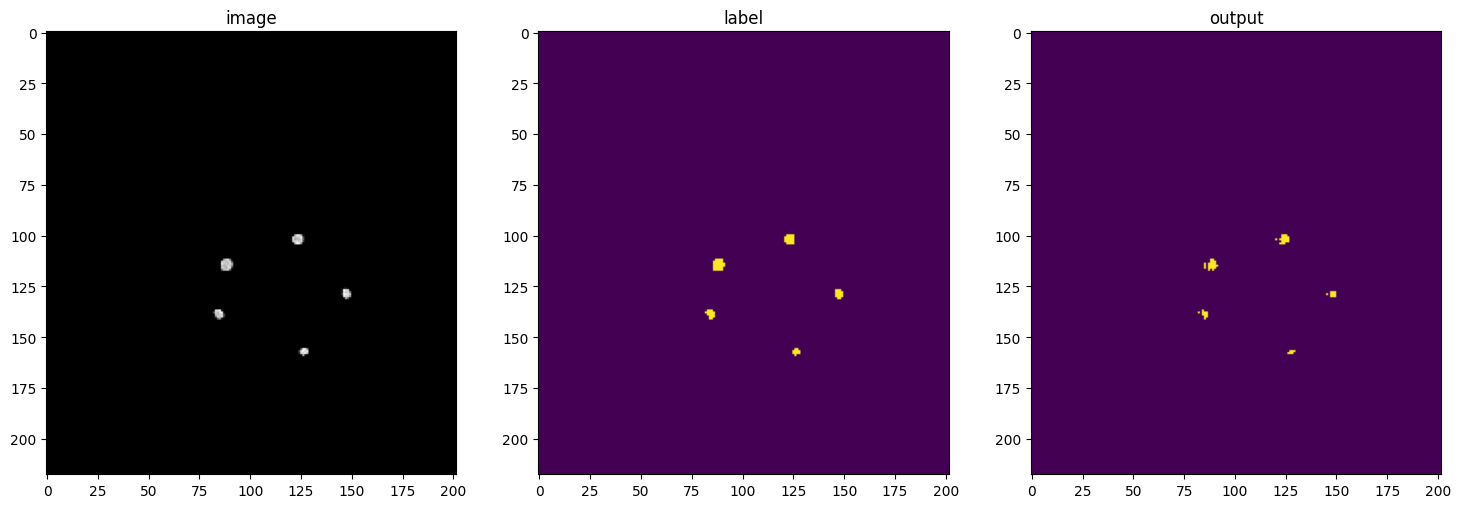

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 1 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 233 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()

torch.Size([1, 1, 223, 242, 268])
torch.Size([1, 1, 223, 242, 268])
torch.Size([1, 1, 223, 242, 268])


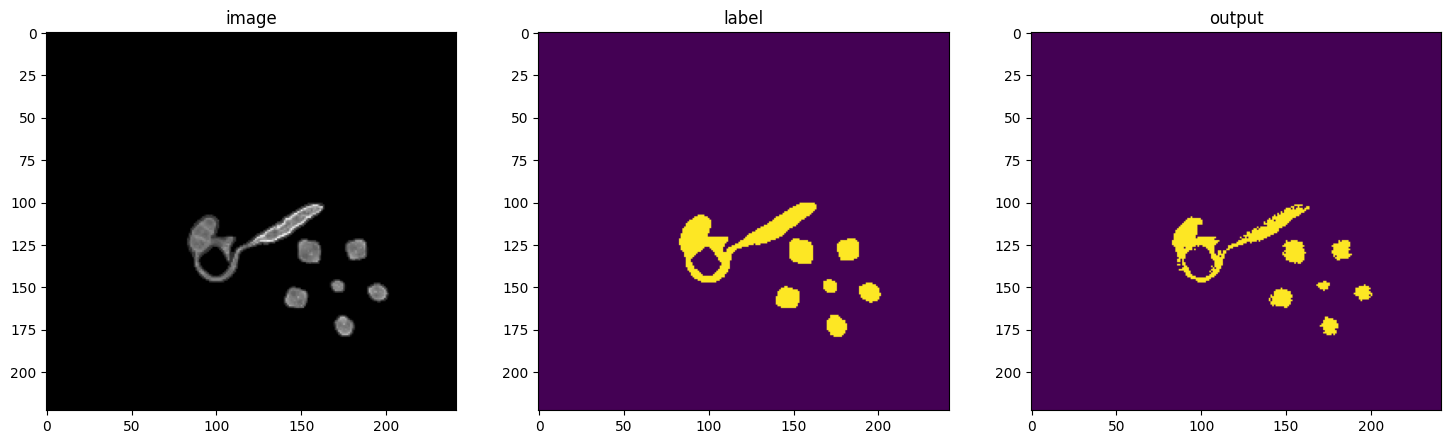

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 2 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 180 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()

torch.Size([1, 1, 223, 242, 268])
torch.Size([1, 1, 223, 242, 268])
torch.Size([1, 1, 223, 242, 268])


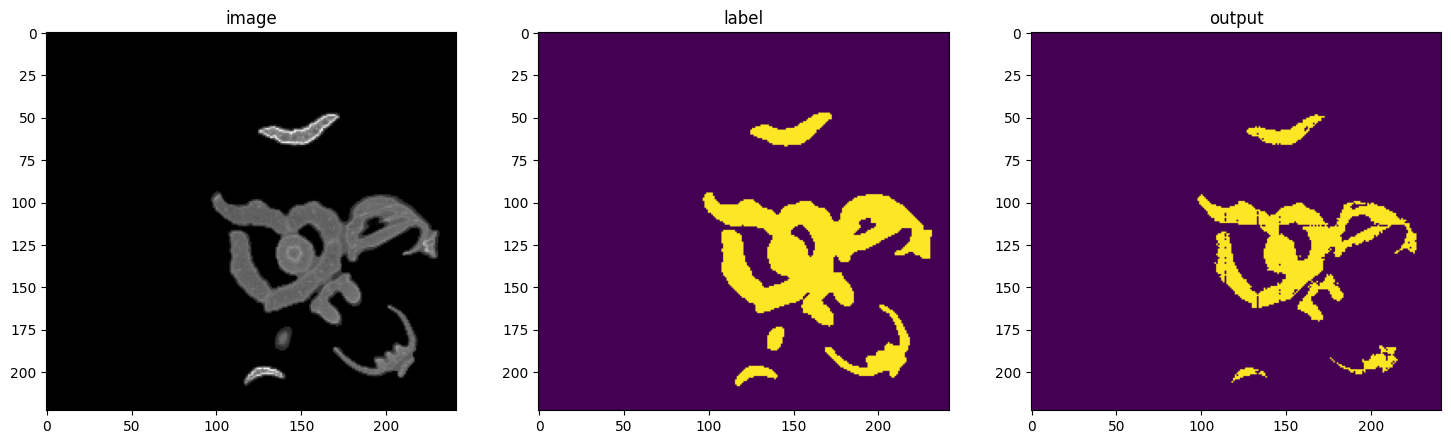

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 2 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 106 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()